In [1]:
#import the packages from the local environment
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/cvx-mpc-stationkeeping`


In [2]:
#packages used 
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools
using DelimitedFiles

In [3]:
include("../src/dynamics.jl")
include("../src/parameters.jl")
include("../src/integrate.jl")

just_dynamics_integrate (generic function with 1 method)

In [4]:
Earth_Moon = ThreeBodySystem_EarthMoon()

ThreeBodySystem(0.01215, 0.98785, 0.01215, [-0.01215, 0.0, 0.0], [0.98785, 0.0, 0.0], 385000.0, 4.349129868518112, 88523.45449302066, 20354.29089708545, [0.8369180073169304, 0.0, 0.0, 0.0, 0.0, 0.0], [1.1556799130947355, 0.0, 0.0, 0.0, 0.0, 0.0])

In [7]:
#use a richardson expansion as the initial guess for the differential corrector 
#saved as a .txt

#this reference trajectory was obtained through ThreeBodyProblem.jl
#halo from richardson expansion
richardson = readdlm("../refs/richardsonL2.txt", '\t', Float64, '\n')'

#period of the halo (in cr3bp units)
T = 3.4071472466192527

#period in days
T_scaled = T*Earth_Moon.time_scale

#initial condition in CR3BP units
x0_L2 = richardson[:,1]

#scaled initial condition
x0_L2_scaled = [x0_L2[1:3]*Earth_Moon.position_scale; x0_L2[4:6]*Earth_Moon.velocity_scale]

6-element Vector{Float64}:
 431249.946141646
      0.0
   5642.062948909701
      0.0
  15342.188285037404
      0.0

In [8]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_in = dynamics_integrate(Earth_Moon ,x_0_stm, T_scaled)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([431249.946141646 431249.9461444589 … 369544.74912909867 369665.9710674015; 0.0 2.1072953725303933 … -45031.76538735194 -45157.53537524888; … ; 15342.188285037404 15342.188246755026 … -2527.477147320156 -1571.3827010368555; 0.0 -0.23903800908705172 … 2308.451334796891 2425.0874238384185], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.00000000622429 5.594567641213317e-14 … 4.337843062628147e-9 3.924109594110078e-14; -2.434276316857394e-14 0.9999999975890765 … 0.0001373529858999031 1.8119307154423863e-19; … ; -5.316833039735577e-10 -3.510551179617628e-5 … 0.999999995594267 5.2767129716926075e-15; 1.2480045464823515e-5 2.5469638239204106e-10 … 4.136769856380186e-14 0.9999999971840383;;; 1.0000000249515597 4.4903309225312285e-13 … 1.7389284798030495e-8 3.14958220963991e-13; -1.9538071544537643e-13 0.999999990335235 … 0.00027500592068671945 2.9117718373904653e-18; … ; -2.1313800807912153e-9 -7.028768607178565e-5 … 0.9999999823385622 4.2352132190747765

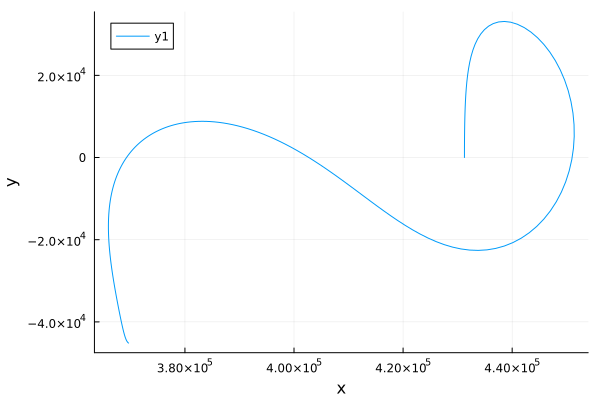

In [9]:
#If we integrate the richardson expansion on the CR3bp dynamics, it is not completely periodic because it is only an approximation 
#this is a plot of the integrated orbit

plot(all_state_in[1,:], all_state_in[2,:], xlabel="x", ylabel="y")

In [10]:
#the purpose of the differential corrector is to make the initial and final state of the orbit the same subject to some tolerance

#fix the richardson expansion guess with a single shooting differential corrector
function differential_corrector(system, x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters
    #for i=1:100

        solution = diff_solve(system, x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        #display(stm)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics_scaled(system, rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #subset of the state transition matrix

        #all 6 variables 
        #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

        #to change x and ydot 

        #keep z0 constant
        #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        #println("this is stm s: ")
        #println(stm_s)


        #keep y0 constant
        #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
        #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]

        delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
        #println("THIS IS CONDITION NUMBER")
        #println(cond((stm_s - dy/rv_dot[2])))

        #delta_x0 = stm_s\δxz

        #update the initial state

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        #x_0_stm[1:6] = x_0_stm[1:6] + delta
        #when delta is below a set tolerance we are done

        println("residual: ", δxz)
        
        #loosen up the tolerance bc of the scaling of the problem
        if norm(δxz) < 1e-6

            #this is the total time, but we use it to ensure we have enough time to find where
            #y crosses the xz plane
            #print("this is sol t: ", sol_t)
            #updating time
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(system, x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [11]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(Earth_Moon, x_0_stm, T_scaled)

residual: [1643.9519839324487, -191.4988002731686]
residual: [2.5062654060160137, 35.414091821322586]
residual: [-495.1171688605523, 60.688781643238784]
residual: [-24.375558852836726, 8.506875803296856]
residual: [-110.46860206507704, 9.540111536783268]
residual: [-13.136193716304701, 1.758026940039784]
residual: [-14.47295436376987, 1.0122384454524755]
residual: [-1.5051816256491617, 0.1252862858144221]
residual: [-0.11466721336305255, 0.007759735519665084]
residual: [-0.0002584322764384862, 1.3541399399075671e-5]
residual: [-4.466341804239009e-6, -1.6699838992584847e-7]
residual: [-1.7181652133684486e-6, -6.467597166466907e-8]
residual: [4.390998454090687e-7, 1.6642285394796388e-8]


([431249.946141646 431249.94614368404 … 431250.7570701569 431249.9459525911; 0.0 2.118659307545513 … -1332.0877095001688 0.0002245328881018195; … ; 15649.016257820032 15649.016219624365 … 15633.915771830501 15649.016342283901; 0.0 -0.09679765124423992 … 60.838081487480196 -7.527633835777027e-6], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.746812490061226e-14 … 4.2144974216198e-9 1.5618037605153313e-14; -2.178985779599666e-14 0.9999999976191183 … 0.00013538610167654265 7.747337710088622e-20; … ; -4.828381381064227e-10 -3.5171730170269434e-5 … 0.9999999956810306 2.28896100118786e-15; 5.112455571955675e-6 1.0493438156541656e-10 … 1.6653248151092917e-14 0.9999999971499303;;; 1.0000000255866435 4.817924242782896e-13 … 1.739273010437185e-8 1.309361013432194e-13; -1.8267845868207107e-13 0.9999999901743841 … 0.000275033162472087 1.3194605279971914e-18; … ; -1.9926156055396843e-9 -7.145040750929283e-5 … 0.9999999821761268 1.91898386168

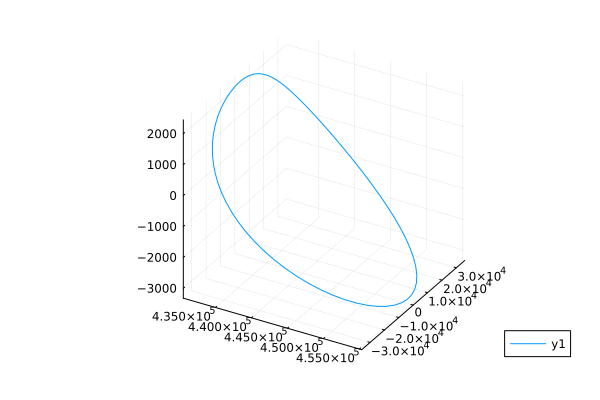

In [12]:
#this is the halo after the differential corrector 
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [13]:
#create a 2 orbit horizon reference trajectory
periodic_initial_condition2 = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic2 = [periodic_initial_condition2; Φ_0]

#integrate for 2 revs
solution_periodic2 = dynamics_integrate(Earth_Moon, x_0_periodic2, 2*sol_t_final[end])

all_state_2, stm_in_2, sol_t_in_2 = get_state_stm(solution_periodic2)

([431249.946141646 431249.94614368404 … 431250.7314396219 431249.71775197727; 0.0 2.118659307545513 … -1477.2971665154118 0.24717429810977687; … ; 15649.016257820032 15649.016219624365 … 15630.538898053826 15649.118285161985; 0.0 -0.09679765124423992 … 67.46673899025373 -0.008976455409325809], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.746812490061226e-14 … 4.2144974216198e-9 1.5618037605153313e-14; -2.178985779599666e-14 0.9999999976191183 … 0.00013538610167654265 7.747337710088622e-20; … ; -4.828381381064227e-10 -3.5171730170269434e-5 … 0.9999999956810306 2.28896100118786e-15; 5.112455571955675e-6 1.0493438156541656e-10 … 1.6653248151092917e-14 0.9999999971499303;;; 1.0000000255866435 4.817924242782896e-13 … 1.739273010437185e-8 1.309361013432194e-13; -1.8267845868207107e-13 0.9999999901743841 … 0.000275033162472087 1.3194605279971914e-18; … ; -1.9926156055396843e-9 -7.145040750929283e-5 … 0.9999999821761268 1.9189838616871

In [15]:
#Check when the orbit leaves
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(Earth_Moon, x_0_stm, 3.5*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([431249.946141646 431249.94614368404 … 443246.7711365753 442751.7573693194; 0.0 2.118659307545513 … 4813.497828788193 3764.0793835602103; … ; 15649.016257820032 15649.016219624365 … -11412.46319839597 -11235.50377184583; 0.0 -0.09679765124423992 … 186.8916600300979 236.2180411772976], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.746812490061226e-14 … 4.2144974216198e-9 1.5618037605153313e-14; -2.178985779599666e-14 0.9999999976191183 … 0.00013538610167654265 7.747337710088622e-20; … ; -4.828381381064227e-10 -3.5171730170269434e-5 … 0.9999999956810306 2.28896100118786e-15; 5.112455571955675e-6 1.0493438156541656e-10 … 1.6653248151092917e-14 0.9999999971499303;;; 1.0000000255866435 4.817924242782896e-13 … 1.739273010437185e-8 1.309361013432194e-13; -1.8267845868207107e-13 0.9999999901743841 … 0.000275033162472087 1.3194605279971914e-18; … ; -1.9926156055396843e-9 -7.145040750929283e-5 … 0.9999999821761268 1.9189838616871862e-14;

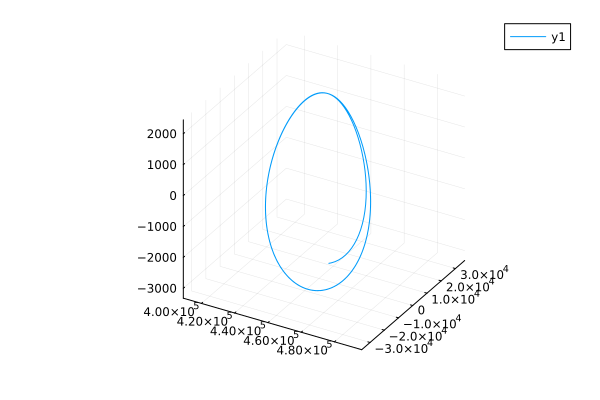

In [16]:
#the orbit after 3.5 revs 
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [17]:
all_state_lp 

6×350 Matrix{Float64}:
     4.3125e5      4.3125e5   …       4.43247e5       4.42752e5
     0.0           2.11866         4813.5          3764.08
  2286.77       2286.77           -2958.5         -2938.9
     0.0           0.0301068      -5071.25        -5616.93
 15649.0       15649.0           -11412.5        -11235.5
     0.0          -0.0967977  …     186.892         236.218

In [ ]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [18]:
nx = 6 #number of states
nu = 3 #number of controls 

N_period = 41  #40 knot points per period per period
N_h = 81 #horizon 2 periods

Δt = (sol_t_final[end]/(N_period-1))

0.3713042891751578

In [20]:
#variables to save all the dynamics jacobians this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [21]:
#this is the corrected period from the differential corrector
T_corrected = sol_t_final[end]

14.852171567006312

In [22]:
#create even timesteps along the horizon 
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.371304, 0.742609, 1.11391, …, 13.7383, 14.1096, 14.4809, 14.8522

In [23]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
